<a href="https://colab.research.google.com/github/Kabixr/Music-Recco/blob/main/AI_Music_Recco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Trying encoding: utf-8
Failed: utf-8 'utf-8' codec can't decode byte 0x85 in position 5: invalid start byte
Trying encoding: latin-1
Loaded shape: (90, 10)
Columns: ['title', 'artist', 'top genre', 'bpm', 'energy', 'danceability', 'liveness', 'valence', 'acousticness', 'speechiness']
Using features: ['danceability', 'energy', 'valence', 'acousticness', 'speechiness']
Saved: emotion_music_plots/feature_correlation.png


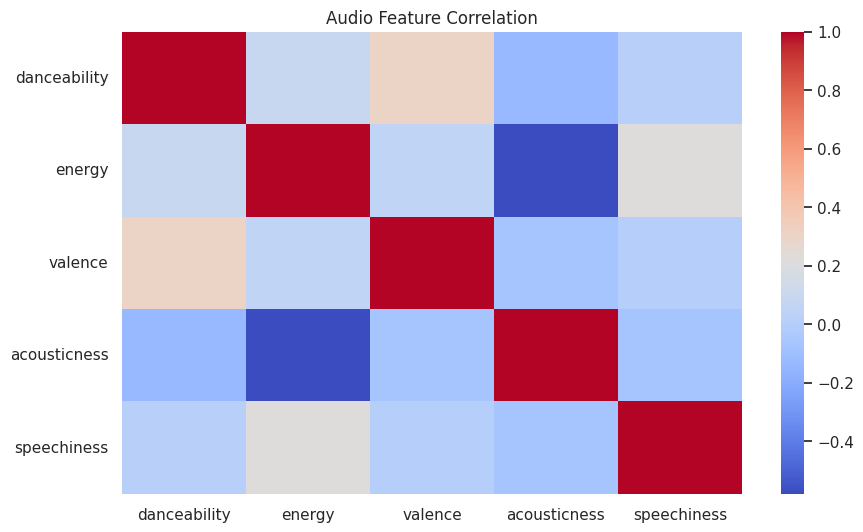

Saved: emotion_music_plots/audio_clusters_pca.png


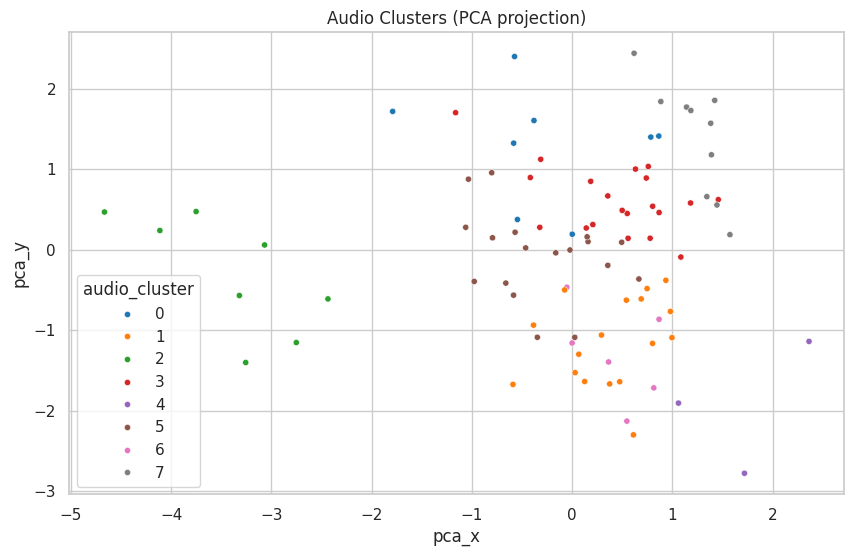


Enter a short sentence describing your mood / what you want (e.g., 'I want upbeat workout music'):

Your mood/text: sad


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Sentiment scores (VADER): {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4767}
Derived target profile (danceability, energy, valence, tempo):
{'danceability': 0.03315499999999999, 'energy': 0.0, 'valence': 0.0, 'tempo': 90.233}
Saved: emotion_music_plots/target_profile_radar.png


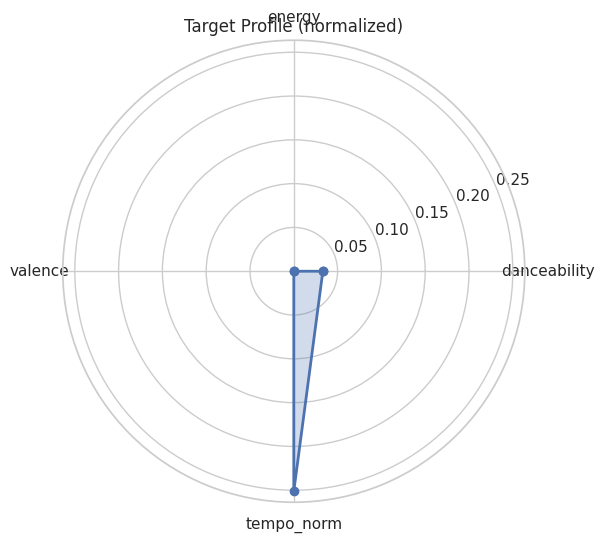


Top 10 recommendations for: 'sad'

1. Bohemian Rhapsody - 2011 Mix — Queen | distance=3.993
2. Dream On — Aerosmith | distance=4.002
3. Knockin' On Heaven's Door - Remastered — Bob Dylan | distance=4.517
4. Dust in the Wind — Kansas | distance=4.623
5. More Than a Feeling — Boston | distance=5.167
6. Mr. Blue Sky — Electric Light Orchestra | distance=5.378
7. Piano Man — Billy Joel | distance=5.589
8. Wish You Were Here — Pink Floyd | distance=5.695
9. Sweet Emotion — Aerosmith | distance=5.926
10. Walk On the Wild Side — Lou Reed | distance=6.048
Saved: emotion_music_plots/top_recommendations_list.png


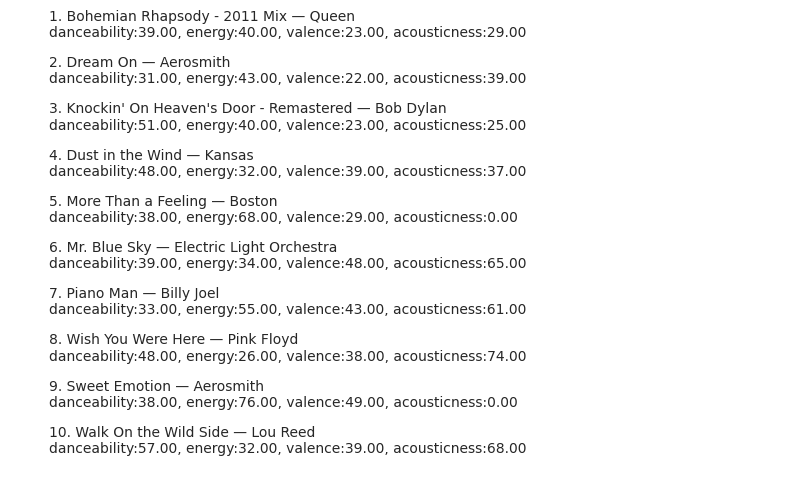


Saved playlist CSV: recommended_playlist.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done. All files downloaded. Enjoy your playlist! ✅


In [3]:
!pip -q install scikit-learn seaborn nltk

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os, math
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from google.colab import files
sns.set(style="whitegrid")

# 1. Load Spotify dataset (encoding fallback) - change URL if you prefer another file
spotify_url = "https://raw.githubusercontent.com/dylanwalker/BA865/master/datasets/spotify.csv"

def load_with_fallback(url):
    encodings = ["utf-8", "latin-1", "ISO-8859-1", "cp1252"]
    last_err = None
    for enc in encodings:
        try:
            print("Trying encoding:", enc)
            return pd.read_csv(url, encoding=enc)
        except Exception as e:
            last_err = e
            print("Failed:", enc, e)
    raise ValueError("Could not load CSV. Last error: " + str(last_err))

df = load_with_fallback(spotify_url)
print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())

# 2. Select / clean features we need (silently ignore missing features)
features = ["danceability","energy","valence","tempo","acousticness","instrumentalness","speechiness","loudness","popularity","duration_ms"]
use_features = [f for f in features if f in df.columns]
print("Using features:", use_features)

# Drop rows missing essential numeric audio features
df_clean = df.dropna(subset=[c for c in use_features if c in df.columns]).reset_index(drop=True)

# Keep a compact metadata subset
meta_cols = []
for c in ["track_name","name","title","song","artist","artists"]:
    if c in df_clean.columns:
        meta_cols.append(c)
# sometimes the dataset uses "name" or "track_name"
if not meta_cols:
    # fallbacks
    if "track_name" not in df_clean.columns and "name" in df_clean.columns:
        meta_cols = ["name"]

# We'll attempt to pick artist and title columns heuristically
title_col = None
artist_col = None
for cand in ["track_name","name","title","song"]:
    if cand in df_clean.columns:
        title_col = cand
        break
for cand in ["artist","artists","artist_name"]:
    if cand in df_clean.columns:
        artist_col = cand
        break

# create columns for display
display_title = title_col if title_col else (df_clean.columns[0] if len(df_clean.columns)>0 else None)
display_artist = artist_col

# 3. Build feature matrix and scaler
X = df_clean[use_features].copy()
# some features like loudness are negative; keep as-is
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Cluster songs into K groups (audio-profile clusters)
K = 8
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_clean["audio_cluster"] = clusters

# 5. Train NearestNeighbors for fast lookup
nn = NearestNeighbors(n_neighbors=100, metric="euclidean")
nn.fit(X_scaled)

# 6. Simple NLP -> audio-profile mapping
# Use VADER for sentiment polarity and keyword rules for mood-intent mapping
sia = SentimentIntensityAnalyzer()

# small rule-based mapping from mood keywords to desired audio features delta
keyword_to_profile = {
    # feature order: danceability, energy, valence, tempo
    "happy":       {"danceability":0.2,"energy":0.2,"valence":0.3,"tempo":10},
    "sad":         {"danceability":-0.15,"energy":-0.3,"valence":-0.4,"tempo":-15},
    "relax":       {"danceability":-0.2,"energy":-0.3,"valence":0.05,"tempo":-20},
    "study":       {"danceability":-0.3,"energy":-0.2,"valence":0.0,"tempo":-10},
    "focus":       {"danceability":-0.25,"energy":-0.15,"valence":0.0,"tempo":-10},
    "workout":     {"danceability":0.25,"energy":0.4,"valence":0.1,"tempo":15},
    "party":       {"danceability":0.4,"energy":0.5,"valence":0.2,"tempo":20},
    "romantic":    {"danceability":0.05,"energy":-0.1,"valence":0.3,"tempo":-5},
    "melancholy":  {"danceability":-0.2,"energy":-0.25,"valence":-0.25,"tempo":-10},
    "happy vibe":  {"danceability":0.25,"energy":0.2,"valence":0.35,"tempo":8}
}

def extract_target_profile(user_text):
    txt = user_text.lower()
    # sentiment-based valence
    s = sia.polarity_scores(txt)
    polarity = s["compound"]  # -1..+1
    # map polarity to valence target between 0..1
    valence_base = (polarity + 1)/2  # 0..1
    # base energy/danceability/tempo from valence (heuristic)
    energy_base = max(0.15, valence_base*0.9)
    dance_base = max(0.05, valence_base*0.7)
    tempo_base = 100 + valence_base*20  # baseline 100 BPM

    # apply keyword boosts
    profile = {"danceability":dance_base, "energy":energy_base, "valence":valence_base, "tempo":tempo_base}
    for kw,delta in keyword_to_profile.items():
        if kw in txt:
            for k,v in delta.items():
                if k in profile:
                    if k!="tempo":
                        profile[k] = min(max(profile[k] + v, 0.0), 1.0)
                    else:
                        profile[k] = max(40, profile[k] + v)
    # clamp
    profile["danceability"] = float(np.clip(profile["danceability"], 0, 1))
    profile["energy"] = float(np.clip(profile["energy"], 0, 1))
    profile["valence"] = float(np.clip(profile["valence"], 0, 1))
    profile["tempo"] = float(max(40, min(profile["tempo"], 240)))
    return profile, s

# 7. Recommendation function
def recommend_from_text(user_text, top_n=10):
    target_profile, sentiment_scores = extract_target_profile(user_text)
    # Build a target vector consistent with use_features
    # We'll only use available audio features: danceability, energy, valence, tempo, acousticness...
    target = []
    for f in use_features:
        if f in ["danceability","energy","valence"]:
            target.append(target_profile[f])
        elif f == "tempo":
            target.append(target_profile["tempo"])
        else:
            # for other features, use dataset median as neutral
            target.append(X[f].median())
    target = np.array(target).reshape(1,-1)
    # scale the target before NN search
    target_scaled = scaler.transform(target)
    distances, indices = nn.kneighbors(target_scaled, n_neighbors=top_n)
    recs = df_clean.iloc[indices[0]].copy()
    recs["distance"] = distances[0]
    # attach display fields
    def title_of(r):
        if display_title and display_title in r.index:
            return r[display_title]
        elif "name" in r.index:
            return r["name"]
        else:
            return "Unknown Title"
    def artist_of(r):
        if display_artist and display_artist in r.index:
            return r[display_artist]
        else:
            return r.get("artist","")
    recs["display_title"] = recs.apply(title_of, axis=1)
    recs["display_artist"] = recs.apply(artist_of, axis=1)
    return recs.reset_index(drop=True), target_profile, sentiment_scores

# 8. Visualizations helper
os.makedirs("emotion_music_plots", exist_ok=True)
def saveplt(name):
    path = f"emotion_music_plots/{name}.png"
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path)

# produce some summary visualizations
plt.figure(figsize=(10,6))
sns.heatmap(pd.DataFrame(X, columns=use_features).corr(), cmap="coolwarm")
plt.title("Audio Feature Correlation")
saveplt("feature_correlation")
plt.show()

# cluster scatter (use first two PCA-like axes via scaled features)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
df_clean["pca_x"] = coords[:,0]; df_clean["pca_y"] = coords[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x="pca_x", y="pca_y", hue="audio_cluster", palette="tab10", s=20, legend="full")
plt.title("Audio Clusters (PCA projection)")
saveplt("audio_clusters_pca")
plt.show()

# 9. Interactive step: ask user for mood text (Colab input)
print("\nEnter a short sentence describing your mood / what you want (e.g., 'I want upbeat workout music'):\n")
user_text = input("Your mood/text: ") or "I want upbeat workout music"

recs, target_profile, sentiment_scores = recommend_from_text(user_text, top_n=20)
print("\nSentiment scores (VADER):", sentiment_scores)
print("Derived target profile (danceability, energy, valence, tempo):")
print(target_profile)

# show radar of target profile (normalized)
labels = ["danceability","energy","valence","tempo_norm"]
tempo_norm = (target_profile["tempo"] - 40) / (200)  # normalize tempo roughly to 0..1
vals = [target_profile["danceability"], target_profile["energy"], target_profile["valence"], tempo_norm]
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
vals += vals[:1]; angles += angles[:1]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, vals, 'o-', linewidth=2)
ax.fill(angles, vals, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Target Profile (normalized)")
saveplt("target_profile_radar")
plt.show()

# 10. Show top recommendations (closest by distance)
top_n = 10
recs_shown = recs.head(top_n).copy()
display_cols = ["display_title","display_artist"] + [f for f in use_features if f in recs_shown.columns] + ["distance"]
print(f"\nTop {top_n} recommendations for: '{user_text}'\n")
for i, row in recs_shown.iterrows():
    title = row["display_title"] if "display_title" in row else row.get(display_title, "Unknown")
    artist = row["display_artist"] if "display_artist" in row else row.get(display_artist,"")
    print(f"{i+1}. {title} — {artist} | distance={row['distance']:.3f}")

# 11. Create a simple visual grid of top recommendations (album-art not available in CSV; we show text)
plt.figure(figsize=(10, (top_n/2)*1.2))
for idx in range(top_n):
    r = recs_shown.iloc[idx]
    title = r.get("display_title", r.get(display_title,"Unknown"))
    artist = r.get("display_artist", r.get(display_artist,""))
    subtitle = f"{artist}\n"
    feats = ", ".join([f"{f}:{r[f]:.2f}" for f in use_features if f in r.index][:4])
    plt.text(0.05, 1 - (idx+0.5)/top_n, f"{idx+1}. {title} — {artist}\n{feats}", fontsize=10)
plt.axis("off")
saveplt("top_recommendations_list")
plt.show()

# 12. Save recommended playlist CSV
playlist_csv = "recommended_playlist.csv"
recs_shown.to_csv(playlist_csv, index=False)
print(f"\nSaved playlist CSV: {playlist_csv}")

# 13. Download all generated assets (plots + playlist)
print("\nDownloading all generated images and playlist...")
for f in glob.glob("emotion_music_plots/*.png"):
    files.download(f)
files.download(playlist_csv)
print("Done. All files downloaded. Enjoy your playlist! ✅")